In [2]:
import pandas as pd
import numpy as np
import random

# Generate synthetic sales data
np.random.seed(42)
random.seed(42)

# Define data parameters
n_customers = 200  # Number of customers
n_transactions = 1000  # Number of transactions

# Generate customer and product data
customer_ids = [f"CUST{str(i).zfill(4)}" for i in range(1, n_customers + 1)]
products = ["Laptop", "Phone", "Tablet", "Headphones", "Smartwatch"]
categories = ["Electronics", "Accessories"]
regions = ["North", "South", "East", "West"]

# Create transaction data
data = {
    "Customer_ID": [random.choice(customer_ids) for _ in range(n_transactions)],
    "Purchase_Date": pd.date_range(start="2024-01-01", periods=n_transactions).to_list(),
    "Product": [random.choice(products) for _ in range(n_transactions)],
    "Category": [random.choice(categories) for _ in range(n_transactions)],
    "Sales_Amount": [round(random.uniform(20, 2000), 2) for _ in range(n_transactions)],
    "Region": [random.choice(regions) for _ in range(n_transactions)],
}

# Create DataFrame
df = pd.DataFrame(data)

# Save dataset for reuse
df.to_csv("synthetic_sales_data.csv", index=False)
print(df.head())


  Customer_ID Purchase_Date     Product     Category  Sales_Amount Region
0    CUST0164    2024-01-01       Phone  Electronics        598.34   East
1    CUST0029    2024-01-02      Tablet  Accessories        564.21  South
2    CUST0007    2024-01-03      Laptop  Accessories       1084.47  North
3    CUST0190    2024-01-04  Smartwatch  Electronics        353.05   West
4    CUST0071    2024-01-05       Phone  Accessories        925.50   West


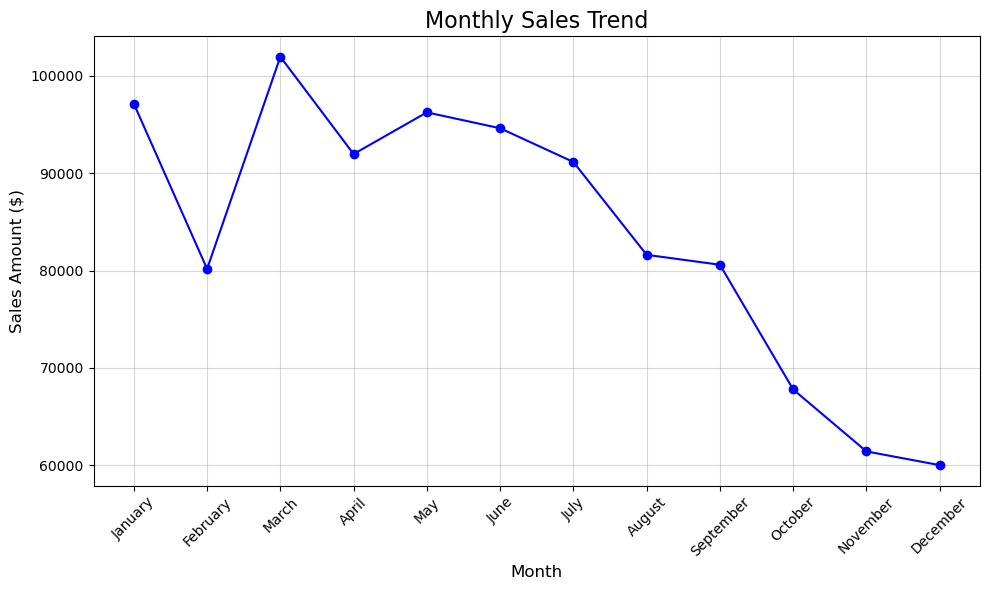

In [5]:
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("synthetic_sales_data.csv")

# Convert Purchase_Date to datetime
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'])
df['Month'] = df['Purchase_Date'].dt.month_name()

# Group by Month and calculate sales
monthly_sales = df.groupby('Month')['Sales_Amount'].sum()

# Sort months in calendar order
month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]
monthly_sales = monthly_sales.reindex(month_order)

# Plot monthly sales trend
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', color='blue')
plt.title("Monthly Sales Trend", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Sales Amount ($)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, alpha=0.5)
plt.tight_layout()
plt.show()

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Avoid memory leak warning on Windows

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Aggregate customer metrics
customer_data = df.groupby('Customer_ID').agg(
    Total_Spend=('Sales_Amount', 'sum'),
    Average_Sale_Value=('Sales_Amount', 'mean'),
    Frequency=('Sales_Amount', 'count')
).reset_index()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['Total_Spend', 'Average_Sale_Value', 'Frequency']])

# Apply K-Means with explicit n_init
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Calculate cluster summary (fix for numeric_only warning)
cluster_summary = customer_data.groupby('Cluster')[
    ['Total_Spend', 'Average_Sale_Value', 'Frequency']
].mean()

print(cluster_summary)

         Total_Spend  Average_Sale_Value  Frequency
Cluster                                            
0        9222.439412         1092.261144   8.588235
1        2389.904516          693.746244   3.532258
2        5221.239231         1144.098860   4.701923


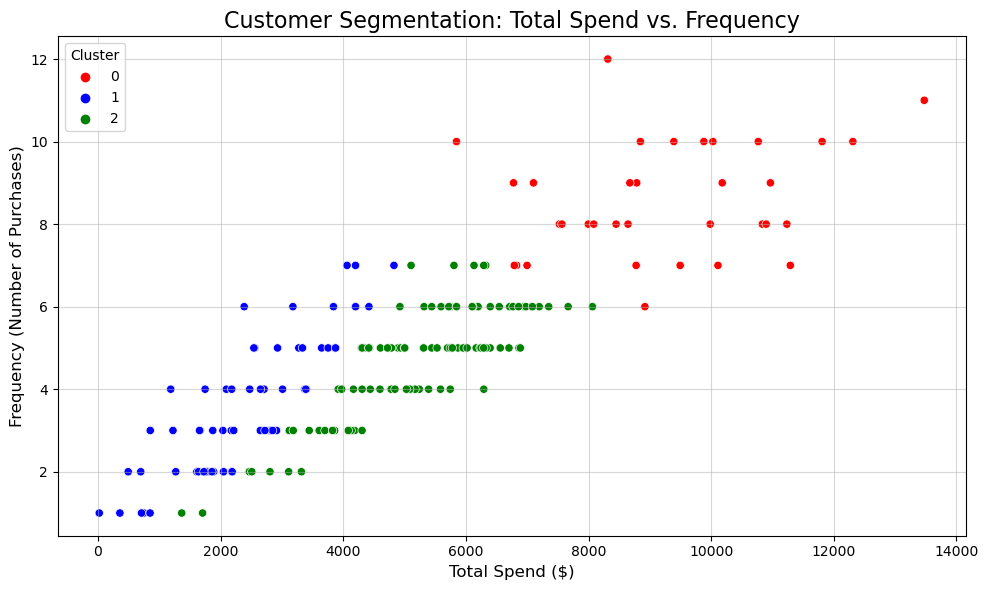

In [6]:
import seaborn as sns

# Map clusters to colors
cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}

# Add cluster color to the dataset
customer_data['Cluster_Color'] = customer_data['Cluster'].map(cluster_colors)

# Scatter plot for Total Spend vs. Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Total_Spend', 
    y='Frequency', 
    hue='Cluster', 
    palette=cluster_colors, 
    data=customer_data
)
plt.title("Customer Segmentation: Total Spend vs. Frequency", fontsize=16)
plt.xlabel("Total Spend ($)", fontsize=12)
plt.ylabel("Frequency (Number of Purchases)", fontsize=12)
plt.legend(title="Cluster")
plt.grid(visible=True, alpha=0.5)
plt.tight_layout()
plt.show()

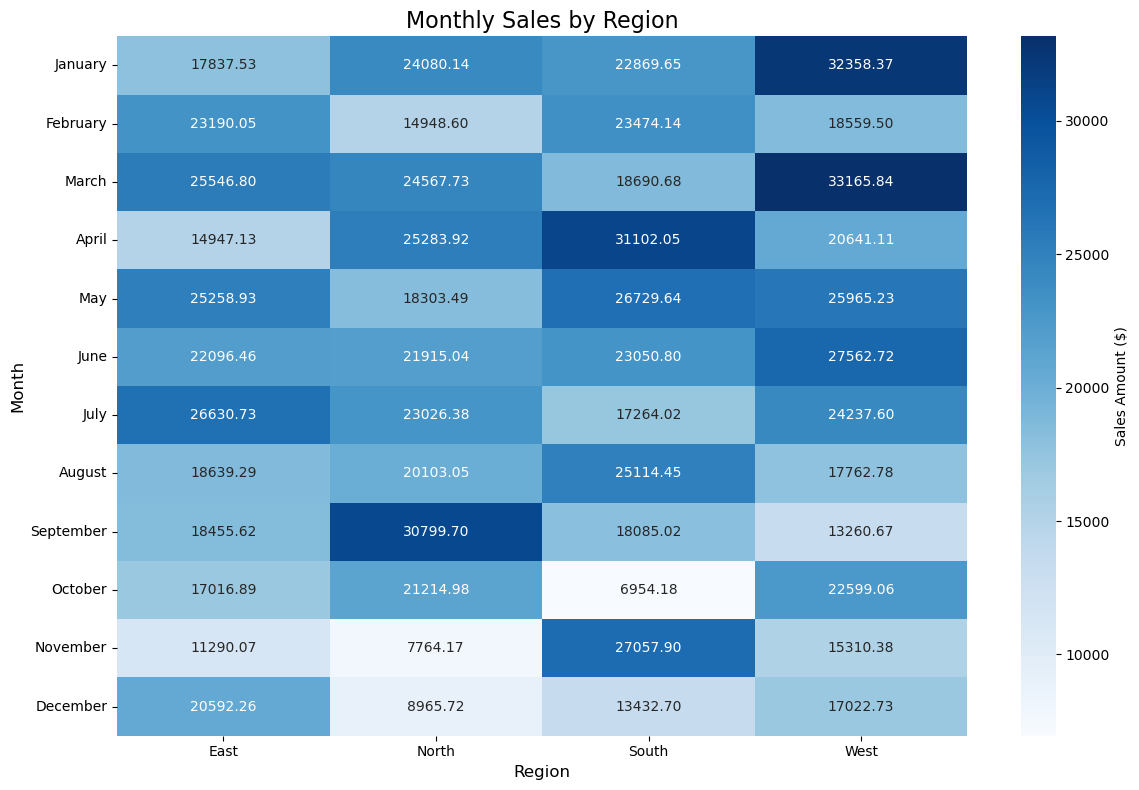

In [7]:
# Aggregate data for heatmap
heatmap_data = df.groupby(['Month', 'Region'])['Sales_Amount'].sum().unstack()

# Sort months in calendar order
heatmap_data = heatmap_data.reindex(index=month_order)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Sales Amount ($)'})
plt.title("Monthly Sales by Region", fontsize=16)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Month", fontsize=12)
plt.tight_layout()
plt.show()
